In [1]:
import numpy as np
import pandas as pd
import math
import os
from msig import Motif, NullModel
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, MSTL
import matplotlib.pylab as pylab
import matplotlib.dates as mdates

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 20}
pylab.rcParams.update(params)


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
data = individual_household_electric_power_consumption.data.features
#date and time col to timestamp
data['timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')
data = data.set_index('timestamp')
data = data.resample('1min').last().ffill()
# largest sequence without nans
data = data.loc['2008-09-01':'2008-10-24']
labels = data[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
labels = labels.map(lambda x: 1 if float(x) > 0 else 0)
data = data.drop(columns=['Date', 'Time', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])
data.replace('?', np.nan, inplace=True) #missing values
data = data.astype(float)
data


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity
timestamp,,,,
2008-09-01 00:00:00,1.300,0.000,243.04,5.4
2008-09-01 00:01:00,1.282,0.000,243.30,5.2
2008-09-01 00:02:00,1.302,0.000,243.40,5.2
2008-09-01 00:03:00,1.284,0.000,243.47,5.2
2008-09-01 00:04:00,1.304,0.000,243.55,5.4
...,...,...,...,...
2008-10-24 23:55:00,0.682,0.000,243.84,2.8
2008-10-24 23:56:00,0.630,0.064,244.69,2.6
2008-10-24 23:57:00,0.620,0.080,245.20,2.6


In [3]:
sr = 1/60
results_path = "../results/household/"+str(sr)
#create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path+"/mp")
    os.makedirs(results_path+"/mp_indices")

In [ ]:
#resid
stats_table = pd.DataFrame()
resids = {}

#get the data for those features
for data_feature in data.columns:
    print(data_feature)
    time_serie = data[data_feature]
    res = MSTL(time_serie, periods=[60*24,60*24*7]).fit() #seasonal period is daily and weekly
    resids[data_feature] = res.resid

    var_resid = np.var(res.resid)
    var_observed = np.var(res.observed)
    trend_strength = max(0, 1 - (var_resid/np.var(res.trend+res.resid)))
    noise_strength = var_resid/var_observed

    seasonal_individial_strengths = {}
    for period in res.seasonal:
        seasonal_individial_strengths["F_"+str(period)] = max(0, 1 - (var_resid/np.var(res.seasonal[period] + res.resid)))
    seasonal_strength = max(0, 1 - (var_resid/np.var(res.seasonal.sum(axis=1) + res.resid)))


    stats_df = {"Feature": data_feature,
                "F_T": round(trend_strength, 3),
                "F_S": round(seasonal_strength, 3), "F_R": round(noise_strength, 3)}
        
    #add individual seasonal strengths to stats_df, rounded with 3 decimals
    for period in seasonal_individial_strengths:
        stats_df[period] = round(seasonal_individial_strengths[period], 3)
            
    stats_table = pd.concat([stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True)

pd.DataFrame(resids).to_csv(results_path+"/resids.csv", index=True)
stats_table

In [4]:
#motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2 # r = np.ceil(m/2)
include = None
normalize = False
subsequence_lengths = [60, 60*3, 60*6] # 1h, 3h, 6h

In [5]:
resids = pd.read_csv(results_path+"/resids.csv", index_col=0).T
resids

timestamp,2008-09-01 00:00:00,2008-09-01 00:01:00,2008-09-01 00:02:00,2008-09-01 00:03:00,2008-09-01 00:04:00,2008-09-01 00:05:00,2008-09-01 00:06:00,2008-09-01 00:07:00,2008-09-01 00:08:00,2008-09-01 00:09:00,...,2008-10-24 23:50:00,2008-10-24 23:51:00,2008-10-24 23:52:00,2008-10-24 23:53:00,2008-10-24 23:54:00,2008-10-24 23:55:00,2008-10-24 23:56:00,2008-10-24 23:57:00,2008-10-24 23:58:00,2008-10-24 23:59:00
Global_active_power,0.506565,0.516621,0.509574,0.534541,0.631358,0.700280,0.462908,0.479826,0.476645,0.476542,...,0.323530,0.219424,0.204339,0.297181,0.277638,0.272184,0.240654,0.225390,0.181213,0.151604
Global_reactive_power,-0.092375,-0.071476,-0.082922,-0.066917,-0.053815,-0.047702,-0.032689,-0.027930,-0.010116,0.009616,...,0.050448,0.058560,0.059963,0.072428,0.057400,0.042402,0.077583,0.090820,0.086248,0.067941
Voltage,-0.473975,-0.270142,-0.508042,-0.787082,-0.997007,-1.028243,-0.755385,-0.578628,-0.466144,-0.667538,...,0.605605,0.866666,0.708139,0.211656,0.111246,0.008962,0.309588,0.523185,0.610972,0.518979
Global_intensity,1.933449,1.979005,1.882688,2.026903,2.520424,2.803456,1.836080,1.894622,1.835589,1.892737,...,1.370533,1.000501,0.890971,1.277681,1.220148,1.174033,1.082572,1.002235,0.779669,0.720115


In [ ]:
for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(resids.values, m, normalize=normalize)
    np.save(results_path+'/mp/normalized={}_m={}_multivariate.npy'.format(normalize,m), mp, allow_pickle=True)
    np.save(results_path+'/mp_indices/normalized={}_m={}_multivariate.npy'.format(normalize,m), mp_indices, allow_pickle=True)

In [6]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))

def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time-m)/np.ceil(m/2)+1))

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]

        #minmax normalize subsequence
        epsilon = 1e-10 # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (max_values - min_values + epsilon)
        ce_norm_subsequence = multivar_subsequence_complexity(normalized_multivar_subsequence)
        norm_ce_norm_subsequence = ce_norm_subsequence/(np.sqrt(len(multivar_subsequence[0])-1)*len(dimensions))

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=0)
            max_allowed_dist = max(np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)]), epsilon)
        
        unified_weights = "0.33,0.33,0.33"
        excl_zone = np.ceil(m/4)
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = w1*(1-(med_dist/max_allowed_dist)) + w2*(len(match_indices)/max_possible_matches) + w3*norm_ce_norm_subsequence

        #remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        #list of indexes to remove
        indexes_to_remove = [i for index in match_indices for i in range(index, index + m)]
        #put zero in the indexes to remove
        time_series_nomatches[:,indexes_to_remove] = 0

        #calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(100 * (1 - (np.mean(np.abs(time_series_nomatches[i])) / np.mean(np.abs(data[i])))))

        variance_explained = np.mean(vars_explained)
    
        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        #max_delta = max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)
        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "CE": np.around(norm_ce_norm_subsequence,3), "Score Unified": np.around(unified,3),
                        "Explained Var(%)": np.around(variance_explained,2),
                        "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.DataFrame.from_records([stats_df]) if mp_stats_table.empty else pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [7]:
min_neighbors = 2
max_distance = None
max_matches = 99999
max_motifs = 99999
cutoff = np.inf
k = None
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    X = resids.values
    mp = np.load(results_path+'/mp/normalized={}_m={}_multivariate.npy'.format(normalize, m), allow_pickle=True)
    mp_indices = np.load(results_path+'/mp_indices/normalized={}_m={}_multivariate.npy'.format(normalize, m), allow_pickle=True)

    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, min_neighbors=min_neighbors, max_distance=max_distance,
                                                                    cutoffs=np.inf, max_matches=max_matches, max_motifs=max_motifs, k=k, include=include, normalize=normalize)  
    
    if len(motif_indices[0]) == 0:
        continue
    print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
    print("Sig ", np.sum(table["p-value"] < 0.001))
    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))
    mp_stats_table = table if mp_stats_table.empty else pd.concat([mp_stats_table, table], ignore_index=True)

    mp_stats_table.to_csv(results_path+'/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs), index=False)

m:60, #Motifs:147
Sig  135
Sig after Hochberg: 135, critical value: 0.0028914735330575333
m:180, #Motifs:115
Sig  108
Sig after Hochberg: 107, critical value: 1.8069944603549198e-51
m:360, #Motifs:123
Sig  119
Sig after Hochberg: 118, critical value: 1.2988536847470417e-78


In [8]:
#read motifs table
mp_stats_table = pd.read_csv(results_path+'/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))

#for motif in mp_stats_table
indexes_to_remove = set()
for index, motif in mp_stats_table.iterrows():
    indexes_to_remove.update([i for index in eval(motif["Indices"]) for i in range(int(index), int(index) + int(motif["m"]))])

datetime_indexes_to_remove = resids.T.index[sorted(indexes_to_remove)]

residual_nomatches = resids.T.copy()
for feature in residual_nomatches.columns:
    residual_nomatches.loc[datetime_indexes_to_remove, feature] = 0
    variance_explained = 100 * (1 - (np.mean(np.abs(residual_nomatches[feature])) / np.mean(np.abs(resids.T[feature]))))
    print(f"{feature}: {variance_explained}")

Global_active_power: 97.30381053111883
Global_reactive_power: 96.63990494556802
Voltage: 97.24139695035878
Global_intensity: 97.26429727337738


In [9]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)

mp_stats_table = pd.read_csv(results_path+'/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
for m in subsequence_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    if table.empty:
        continue
    n_motifs = table.shape[0]
    n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
    avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
    avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
    avg_probability = table["P"].mean(), table["P"].std()    
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.001)": n_sig_motifs_0001, "significant":(n_sig_motifs_0001*100)/n_motifs,
                "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features}
    
    motif_stats_table = pd.DataFrame.from_records([stats_df]) if motif_stats_table.empty else pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
60 & 147 & 135 & 91.836735 & (12.0, 15.834) & (2.71, 0.836) \\
180 & 115 & 108 & 93.913043 & (6.36, 7.232) & (2.74, 0.636) \\
360 & 123 & 119 & 96.747967 & (3.95, 2.482) & (2.91, 0.512) \\
\bottomrule
\end{tabular}



In [10]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        #label x with i+index
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)

        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig(results_path+'/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  60


KeyboardInterrupt: 

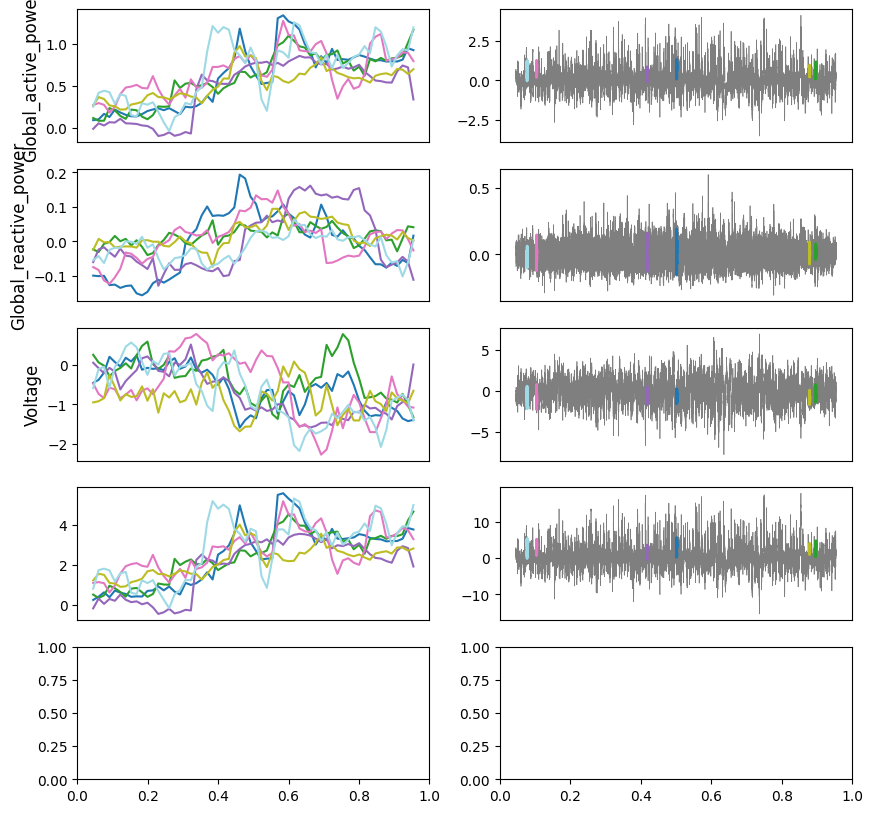

In [12]:
#plot top motif
mp_stats_table = pd.read_csv(results_path+'/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
subsequence_lengths = mp_stats_table["m"].unique()
ts = resids
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = sorted([int(dimension) for dimension in dimensions])
        features = [resids.T.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [resids.T[feature] for feature in features]
        ts_list.append(labels)
        features.append("label")
        plot_motif(ts_list, features, m, indices, motif_name)